In [1]:
import torch
import torch.nn as nn
import numpy as np
import pickle, os
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Original ConvLSTM cell as proposed by Shi et al.
class ConvLSTMCell(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size, padding, activation, frame_size
    ):

        super(ConvLSTMCell, self).__init__()

        if activation == "tanh":
            self.activation = torch.tanh
        elif activation == "relu":
            self.activation = torch.relu

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels,
            out_channels=4 * out_channels,
            kernel_size=kernel_size,
            padding=padding,
        )

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.rand(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.rand(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.rand(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev)
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev)

        # Current Cell output
        C = forget_gate * C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C)

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C


In [3]:
class ConvLSTM(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size, padding, activation, frame_size
    ):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(
            in_channels, out_channels, kernel_size, padding, activation, frame_size
        )

    def forward(self, X):

        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)

        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size()

        # Initialize output
        output = torch.zeros(
            batch_size, self.out_channels, seq_len, height, width, device=device
        )

        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, height, width, device=device)

        # Initialize Cell Input
        C = torch.zeros(batch_size, self.out_channels, height, width, device=device)

        # Unroll over time steps
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:, :, time_step], H, C)

            output[:, :, time_step] = H

        return output


In [4]:
class Seq2Seq(nn.Module):
    def __init__(
        self,
        num_channels,
        num_kernels,
        kernel_size,
        padding,
        activation,
        frame_size,
        num_layers,
    ):

        super(Seq2Seq, self).__init__()

        self.sequential = nn.Sequential()

        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1",
            ConvLSTM(
                in_channels=num_channels,
                out_channels=num_kernels,
                kernel_size=kernel_size,
                padding=padding,
                activation=activation,
                frame_size=frame_size,
            ),
        )

        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        )

        # Add rest of the layers
        for l in range(2, num_layers + 1):

            self.sequential.add_module(
                f"convlstm{l}",
                ConvLSTM(
                    in_channels=num_kernels,
                    out_channels=num_kernels,
                    kernel_size=kernel_size,
                    padding=padding,
                    activation=activation,
                    frame_size=frame_size,
                ),
            )

            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_kernels)
            )

        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels,
            out_channels=num_channels,
            kernel_size=kernel_size,
            padding=padding,
        )

    def forward(self, X):

        # Forward propagation through all the layers
        output = self.sequential(X)

        # Return only the last output frame
        output = self.conv(output[:, :, -1])

        return nn.Sigmoid()(output)


### Test `ConvLSTMCell` and `ConvLSTM` classes


In [5]:
in_channels = 1
out_channels = 10
kernel_size = 3
padding = "same"
activation = "relu"
frame_size = (5, 5)
batch_size = 4
seq_length = 10


In [6]:
lstm1 = ConvLSTMCell(
    in_channels, out_channels, kernel_size, padding, activation, frame_size
)
torch.manual_seed(1)
X = torch.rand(batch_size, in_channels, seq_length, *frame_size)
H = torch.zeros(batch_size, out_channels, *frame_size)
C = torch.zeros(batch_size, out_channels, *frame_size)
O1 = torch.zeros(batch_size, out_channels, seq_length, *frame_size)
for timestep in range(seq_length):
    H, C = lstm1(X[:, :, timestep], H, C)
    O1[:, :, timestep] = H

print(X.shape)
print(O1.shape)


torch.Size([4, 1, 10, 5, 5])
torch.Size([4, 10, 10, 5, 5])


In [7]:
lstm2 = ConvLSTM(
    in_channels, out_channels, kernel_size, padding, activation, frame_size
)
torch.manual_seed(1)
X = torch.rand(batch_size, in_channels, seq_length, *frame_size)
O2 = lstm2(X)

print(X.shape)
print(O2.shape)


torch.Size([4, 1, 10, 5, 5])
torch.Size([4, 10, 10, 5, 5])


In [8]:
# This should give the same answer.
print(O1[0, 0, -1, 0])
print(O2[0, 0, -1, 0])



tensor([0.0138, 0.0472, 0.0591, 0.0566, 0.0093], grad_fn=<SelectBackward0>)
tensor([0., 0., 0., 0., 0.], grad_fn=<SelectBackward0>)


### Test `Seq2Seq` class


In [9]:
num_channels = in_channels
num_kernels = out_channels
num_layers = 3

lstm3 = Seq2Seq(
    num_channels, num_kernels, kernel_size, padding, activation, frame_size, num_layers
)

X = torch.rand(batch_size, num_channels, seq_length, *frame_size)
O3 = lstm3(X)

print(X.size())
print(O3.size())


torch.Size([4, 1, 10, 5, 5])
torch.Size([4, 1, 5, 5])


### PFC data


- Be careful when setting batch_size to 1 because BatchNorm will not work correctly.
- https://discuss.pytorch.org/t/model-eval-gives-incorrect-loss-for-model-with-batchnorm-layers/7561

In [10]:
in_channels = 1
out_channels = 10
kernel_size = (1, 3)
padding = "same"
activation = "tanh"
frame_size = (1, 32)
batch_size = 10 
seq_length = 10
num_channels = in_channels
num_kernels = out_channels
num_layers = 2


In [11]:
# Data folder
cwd = os.getcwd()
folderPFC = "T02 - PFC - ConvLSTM"
folderOutput = "2022-05-08-07-21-22"
rootFolder = os.path.dirname(cwd)  # Up one level
filePath = os.path.join(
    rootFolder, folderPFC, "output", folderOutput, "data_store.pickle"
)
print(filePath)


/home/nnnpooh/Coding/research/pfc-ml/T02 - PFC - ConvLSTM/output/2022-05-08-07-21-22/data_store.pickle


In [12]:
# Load data (deserialize)
with open(filePath, "rb") as handle:
    data_dict = pickle.load(handle)

data = data_dict["data"]
# nCol = data_dict["n"]
# nRow = 1
# nChannel = 1
# tFinal = data_dict["tf"]
# dx = data_dict["dx"]
# L = data_dict["L"]


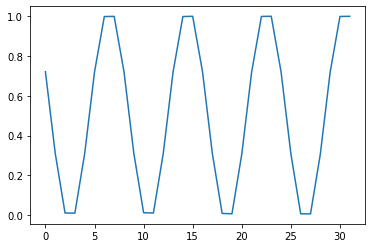

In [13]:
# Due to sigmoid function, the output cannot be negative.  I could however, use linear layer to fix this?
maxVal = data.max()
minVal = data.min()
dataScaled = (data - minVal) / (maxVal - minVal)
plt.plot(dataScaled[-1, :])

In [14]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_length, num_channels, frame_size):
        X_, y_ = self.split_sequence(data, seq_length)
        X_ = X_.reshape(X_.shape[0], num_channels, seq_length, *frame_size)
        self.X = torch.from_numpy(
            X_
        ).float()  # numpy array data is double but the parameters in the nn layers are float.
        self.y = torch.from_numpy(y_).float()

    def __len__(self):
        "Denotes the total number of samples"
        return self.X.shape[0]

    # Probabably a better way here: https://diegslva.github.io/2017-05-02-first-post/
    def split_sequence(self, data, nSeq):
        X, y = list(), list()
        nRow = data.shape[0]
        for i in range(nRow):
            # find the end of this pattern
            end_ix = i + nSeq
            # check if we are beyond the sequence
            if end_ix > nRow - 1:
                break
                # gather input and output parts of the pattern
            seq_x, seq_y = data[i:end_ix, :], data[end_ix, :]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

    def __getitem__(self, index):
        "Generates one sample of data"
        # Select sample
        X = self.X[index]
        y = self.y[index]
        return X, y


In [15]:
ds = MyDataset(dataScaled, seq_length, num_channels, frame_size)
train_loader = DataLoader(ds, shuffle=True, batch_size=batch_size)


torch.Size([10, 1, 10, 1, 32])
torch.Size([10, 32])


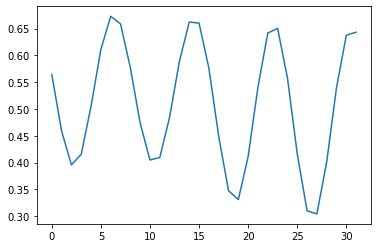

In [16]:
train_, phi_ = next(iter(train_loader))
print(train_.shape)
print(phi_.shape)
train = train_[0, 0, -1, 0, :].cpu().detach().numpy()
plt.plot(train)
plt.show()


In [17]:
model = Seq2Seq(
    num_channels, num_kernels, kernel_size, padding, activation, frame_size, num_layers
)

optim = Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss(reduction="sum")



In [18]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(
        self, patience=7, verbose=False, delta=0, path="checkpoint.pt", trace_func=print
    ):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [19]:
class History:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.epoch = []
        self.counter = 1
    def __call__(self, train_loss, val_loss):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.epoch.append(self.counter)
        self.counter += 1


In [20]:
num_epochs = 1000
patience = 20
history = History()

In [34]:
early_stopping = EarlyStopping(patience=patience, verbose=True)
for epoch in range(1, num_epochs + 1):

    train_loss = 0
    model.train()  # https://stackoverflow.com/a/51433411
    for batch_num, (input, target) in enumerate(train_loader, 1):
        output = model(input)
        loss = criterion(output.flatten(), target.flatten())
        loss.backward()
        optim.step()
        optim.zero_grad()
        train_loss += loss.item()
    train_loss /= len(train_loader.dataset)

    val_loss = 0
    model.train()
    with torch.no_grad():
        for input, target in train_loader:
            output = model(input)
            loss = criterion(output.flatten(), target.flatten())
            val_loss += loss.item()
    val_loss /= len(train_loader.dataset)

    history(train_loss, val_loss)
    print(
        "Epoch:{} Training Loss:{:.8f} Validation Loss:{:.8f}\n".format(
            epoch, train_loss, val_loss
        )
    )

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break


Epoch:1 Training Loss:0.00345524 Validation Loss:0.00324101

Validation loss decreased (inf --> 0.003241).  Saving model ...
Epoch:2 Training Loss:0.00268276 Validation Loss:0.00214799

Validation loss decreased (0.003241 --> 0.002148).  Saving model ...
Epoch:3 Training Loss:0.00138058 Validation Loss:0.00230614

EarlyStopping counter: 1 out of 20
Epoch:4 Training Loss:0.00230954 Validation Loss:0.00235851

EarlyStopping counter: 2 out of 20
Epoch:5 Training Loss:0.00139007 Validation Loss:0.00121060

Validation loss decreased (0.002148 --> 0.001211).  Saving model ...
Epoch:6 Training Loss:0.00115618 Validation Loss:0.00103530

Validation loss decreased (0.001211 --> 0.001035).  Saving model ...
Epoch:7 Training Loss:0.00120856 Validation Loss:0.00154669

EarlyStopping counter: 1 out of 20
Epoch:8 Training Loss:0.00205210 Validation Loss:0.00160491

EarlyStopping counter: 2 out of 20
Epoch:9 Training Loss:0.00122805 Validation Loss:0.00130168

EarlyStopping counter: 3 out of 20
Epoch

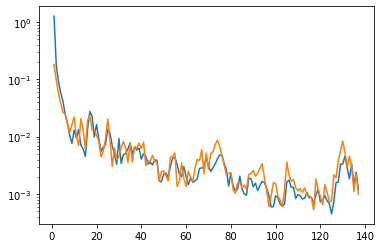

In [35]:
fig, ax = plt.subplots()
ax.plot(history.epoch, history.train_losses)
ax.plot(history.epoch, history.val_losses)
ax.set_yscale('log')

torch.Size([10, 1, 1, 32])
torch.Size([10, 32])


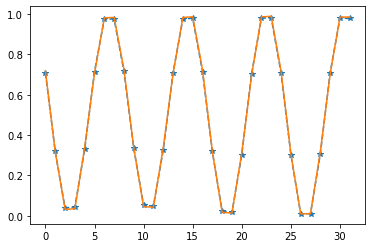

In [38]:
train_, phi_ = next(iter(train_loader))
model.eval()
pred_ = model(train_)
print(pred_.size())
print(phi_.size())

pred = pred_[-1, 0, 0, :].cpu().detach().numpy()
phi = phi_[-1, :].cpu().detach().numpy()
plt.plot(phi, "--*")
plt.plot(pred)


#### For debugging


In [24]:
# model = Seq2Seq(
#     num_channels, num_kernels, kernel_size, padding, activation, frame_size, 10
# )

# optim = Adam(model.parameters(), lr=1e-4)
# criterion = nn.MSELoss(reduction="sum")

# input, target = next(iter((train_loader)))
# output = model(input)
# loss = criterion(output.flatten(), target.flatten())
# loss.backward()
# optim.step()
# optim.zero_grad()
# print(output)


### Single batch testing

In [25]:
# num_epochs = 1000
# (input, target) = next(iter(train_loader))

# for epoch in range(1, num_epochs + 1):

#     train_loss = 0
#     model.train() #https://stackoverflow.com/a/51433411
#     output = model(input)
#     loss = criterion(output.flatten(), target.flatten())
#     loss.backward()
#     optim.step()
#     optim.zero_grad()
#     train_loss += loss.item()
#     train_loss /= batch_size

#     val_loss = 0
#     model.eval()
#     with torch.no_grad():
#         output = model(input)
#         loss = criterion(output.flatten(), target.flatten())
#         val_loss += loss.item()
#     val_loss /= batch_size

#     print(
#         "Epoch:{} Training Loss:{:.8f} Validation Loss:{:.8f}\n".format(
#             epoch, train_loss, val_loss
#         )
#     )


# phiPred = output[-1,0,0,:].cpu().detach().numpy()
# phi = target[-1,:].cpu().detach().numpy()
# plt.plot(phi, '--*')
# plt.plot(phiPred)